In [90]:
import cv2
import datetime as dt
import glob
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from keras import models, layers, optimizers
from tensorflow.keras.applications import Xception
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

In [47]:
train_path = 'C:/Users\Muhammad_Ali/dataset/train'
val_path = 'C:/Users\Muhammad_Ali/dataset/test'

In [48]:
# re-size all the images to a size Xception_model expects.
IMAGE_SIZE = [224, 224]

# Set the batch size
BATCH_SIZE = 15 
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
NUM_CLASSES = 3

In [49]:
import os
CLASSES = os.listdir(train_path)
NUM_CLASSES = len(CLASSES)

In [50]:
print("Class --> {} \n and the length is : {}".format(CLASSES, NUM_CLASSES))

Class --> ['NEGATIVE', 'NEUTRAL', 'POSITIVE'] 
 and the length is : 3


In [51]:
CLASSES

['NEGATIVE', 'NEUTRAL', 'POSITIVE']

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range = 0.2,
    zoom_range = 0.2
)
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=IMAGE_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(val_path, 
                                                  target_size=IMAGE_SIZE, 
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='categorical')

Found 1599 images belonging to 3 classes.
Found 533 images belonging to 3 classes.


In [56]:
# Initialize the base model
base_model = Xception(weights='imagenet',
                      include_top=False,
                      input_shape=(224,224, 3))

In [57]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [58]:
def extract_features(sample_count, datagen):
    start = dt.datetime.now()
    features = np.zeros(shape=(sample_count, 7, 7, 2048))
    labels = np.zeros(shape=(sample_count,3))
    generator = datagen
    i = 0
    for inputs_batch,labels_batch in generator:
        stop = dt.datetime.now()
        time = (stop - start).seconds
        print('\r','Extracting features from batch', str(i+1), '/', len(datagen),
              '-- run time:', time,'seconds',end='')
        features_batch = base_model.predict(inputs_batch)
        features[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = features_batch
        labels[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = labels_batch
        i += 1
        if i * BATCH_SIZE >= sample_count:
            break
    print("\n")
    return features,labels

In [59]:
train_features, train_labels = extract_features(1599, train_generator)
test_features, test_labels = extract_features(533, test_generator)

1/1 [==============================] - 1s 1s/steptime: 223 secon


1/1 [==============================] - 2s 2s/stepme: 72 secon




In [63]:
flat_dim = 7 * 7 * 2048
train_features = np.reshape(train_features, (1599, flat_dim))
test_features = np.reshape(test_features, (533, flat_dim))

In [74]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

In [75]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=flat_dim))
model.add(layers.Dropout(0.8))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 512)               51380736  
                                                                 
 dropout_11 (Dropout)        (None, 512)               0         
                                                                 
 dense_23 (Dense)            (None, 3)                 1539      
                                                                 
Total params: 51,382,275
Trainable params: 51,382,275
Non-trainable params: 0
_________________________________________________________________


In [76]:
history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=callbacks)

Epoch 1/20
86/86 [==============================] - 18s 199ms/step - loss: 7.8070 - acc: 0.6419 - val_loss: 1.5886 - val_acc: 0.8000 - lr: 0.0010
Epoch 2/20
86/86 [==============================] - 17s 198ms/step - loss: 1.0498 - acc: 0.7428 - val_loss: 0.4559 - val_acc: 0.8531 - lr: 0.0010
Epoch 3/20
86/86 [==============================] - 16s 188ms/step - loss: 0.5834 - acc: 0.7506 - val_loss: 0.5021 - val_acc: 0.8469 - lr: 0.0010
Epoch 4/20
86/86 [==============================] - 16s 190ms/step - loss: 0.5168 - acc: 0.7819 - val_loss: 0.5277 - val_acc: 0.8344 - lr: 0.0010
Epoch 5/20
86/86 [==============================] - 17s 194ms/step - loss: 0.5160 - acc: 0.7780 - val_loss: 0.5017 - val_acc: 0.8594 - lr: 0.0010
Epoch 6/20
86/86 [==============================] - 17s 194ms/step - loss: 0.5526 - acc: 0.7748 - val_loss: 0.5154 - val_acc: 0.8219 - lr: 0.0010
Epoch 7/20
86/86 [==============================] - ETA: 0s - loss: 0.5622 - acc: 0.7553
Epoch 7: ReduceLROnPlateau reducing

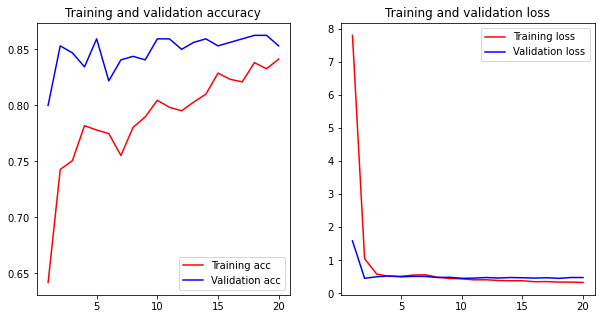

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

ax[0].set_title('Training and validation accuracy')
ax[0].plot(epochs, acc, 'red', label='Training acc')
ax[0].plot(epochs, val_acc, 'blue', label='Validation acc')

ax[1].set_title('Training and validation loss')
ax[1].plot(epochs, loss, 'red', label='Training loss')
ax[1].plot(epochs, val_loss, 'blue', label='Validation loss')

ax[0].legend()
ax[1].legend()

In [79]:
train_features[0].shape

(100352,)

In [80]:
preds = model.predict(test_features)

17/17 [==============================] - 1s 51ms/step


In [81]:
preds[0].argmax()

1

In [82]:
test_labels[0]

array([0., 1., 0.])

In [86]:
# Change labels from one-hot encoded
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]

s = set(y_true)
temp3 = [x for x in predictions if x not in s]
print(temp3)

[]


In [87]:
def plot_confusion_matrix(cm, target_names,title='Confusion matrix',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)
        

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel("Predicted label\naccuracy={:0.4f}\n misclass={:0.4f}".format(accuracy, misclass))
    plt.show()

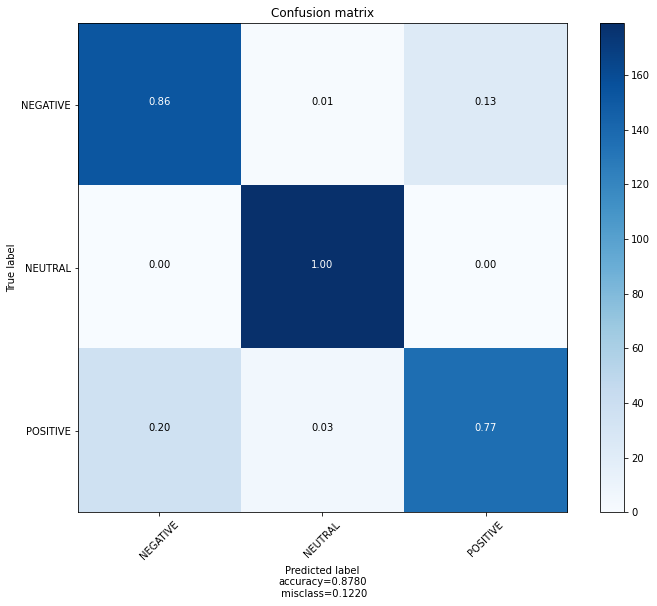

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.81      0.86      0.84       177
     NEUTRAL       0.97      1.00      0.98       179
    POSITIVE       0.86      0.77      0.81       177

    accuracy                           0.88       533
   macro avg       0.88      0.88      0.88       533
weighted avg       0.88      0.88      0.88       533



In [91]:
cm = confusion_matrix(y_pred=predictions, y_true=y_true)
clr = classification_report(y_true,predictions, target_names=CLASSES)
plot_confusion_matrix(cm, normalize=True, target_names=CLASSES)
print("Classification Report:\n----------------------\n", clr)